In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA



# Cleaning

In [134]:
flu = pd.read_csv("data.csv")
#in percentage
flu["prctConsultations"] = flu["prctConsultations"]/100
#the number of people consulted for flu in the sample
flu["consultaion"] = flu["prctConsultations"]* flu["totalConsultationsExtrapolation"]
#percentage of consultation in the sample
flu["sampleconsultation"] = flu["consultaion"]/flu["popExtrapolation"]
flu["georegion"] = flu["georegion"].astype(str)
#keep only the whole ch
flu = flu.loc[flu["georegion"] == "CH"]
# Select only the desired columns
flu_clean = flu[["sampleconsultation", "temporal"]]

# Remove 'W' from the "temporal" column and replace any non-numeric characters
flu_clean["temporal"] = flu_clean["temporal"].str.replace('W', '')
#CHANGE into datetime
flu_clean["temporal"] = flu_clean["temporal"] + "-1"
flu_clean["temporal"] = pd.to_datetime(flu_clean["temporal"],format='%Y-%W-%w')
flu_clean["temporal"]
#sort by time
flu_clean = flu_clean.sort_values(by='temporal')

#sum up the consultation
sum_by_temporal = flu_clean.groupby('temporal')['sampleconsultation'].sum().reset_index()

# Merge the summed values back into the original DataFrame if needed
flu_clean = pd.merge(flu_clean, sum_by_temporal, on='temporal', how='left', suffixes=('', '_sum'))
flu_clean = flu_clean.drop_duplicates(subset='temporal')
flu_clean.info()

flu_clean['sampleconsultation_sum'] = flu_clean['sampleconsultation_sum']* 100000

flu_clean_imputed = flu_clean.copy()
imputer = KNNImputer(n_neighbors=10)
# Reshape the target column to a 2D array (required by the imputer)
impute_data = flu_clean_imputed['sampleconsultation_sum'].values.reshape(-1, 1)
flu_clean_imputed['sampleconsultation_sum'] = imputer.fit_transform(impute_data)
flu_clean_imputed['sampleconsultation_sum'].isnull().any()
#No missing value

flu_clean_imputed.reset_index()
flu_clean_imputed = flu_clean_imputed.drop("sampleconsultation", axis=1)
flu_clean_imputed['temporal'] = pd.to_datetime(flu_clean['temporal'])
flu_clean_imputed = flu_clean_imputed.set_index('temporal')
flu_clean_imputed.index = flu_clean_imputed.index.strftime('%Y-%m-%d')
flu_clean_imputed

<class 'pandas.core.frame.DataFrame'>
Index: 565 entries, 0 to 5660
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   sampleconsultation      448 non-null    float64       
 1   temporal                565 non-null    datetime64[ns]
 2   sampleconsultation_sum  565 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 17.7 KB


,sampleconsultation_sum
temporal,
2013-01-07,618.991084
2013-01-14,1153.639593
2013-01-21,1650.963391
2013-01-28,2486.070312
2013-02-04,3344.993948
...,...
2023-10-09,304.591134
2023-10-16,352.555213
2023-10-23,466.613896


Graph it

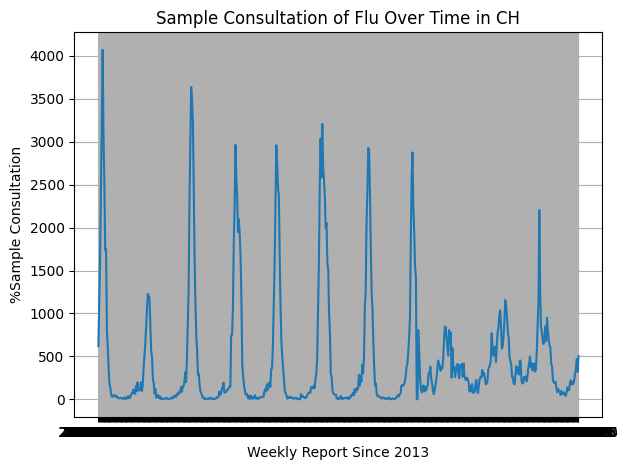

In [135]:
plt.plot(flu_clean_imputed['sampleconsultation_sum'], linestyle='-')
plt.title('Sample Consultation of Flu Over Time in CH')
plt.xlabel('Weekly Report Since 2013')
plt.ylabel('%Sample Consultation')
plt.grid(True)
plt.tight_layout()
plt.show()

# Decomposition

In [136]:
train = flu_clean_imputed[:416]
test = flu_clean_imputed[416:]
print(train)
print(test)

            sampleconsultation_sum
temporal                          
2013-01-07              618.991084
2013-01-14             1153.639593
2013-01-21             1650.963391
2013-01-28             2486.070312
2013-02-04             3344.993948
...                            ...
2020-11-30              507.284570
2020-12-07              806.917334
2020-12-14              666.771190
2020-12-21              777.977861
2020-12-28              251.760453

[416 rows x 1 columns]
            sampleconsultation_sum
temporal                          
2021-01-04              593.719333
2021-01-11              346.315705
2021-01-18              374.134097
2021-01-25              258.128708
2021-02-01              334.725645
...                            ...
2023-10-09              304.591134
2023-10-16              352.555213
2023-10-23              466.613896
2023-10-30              318.747040
2023-11-06              502.424115

[149 rows x 1 columns]


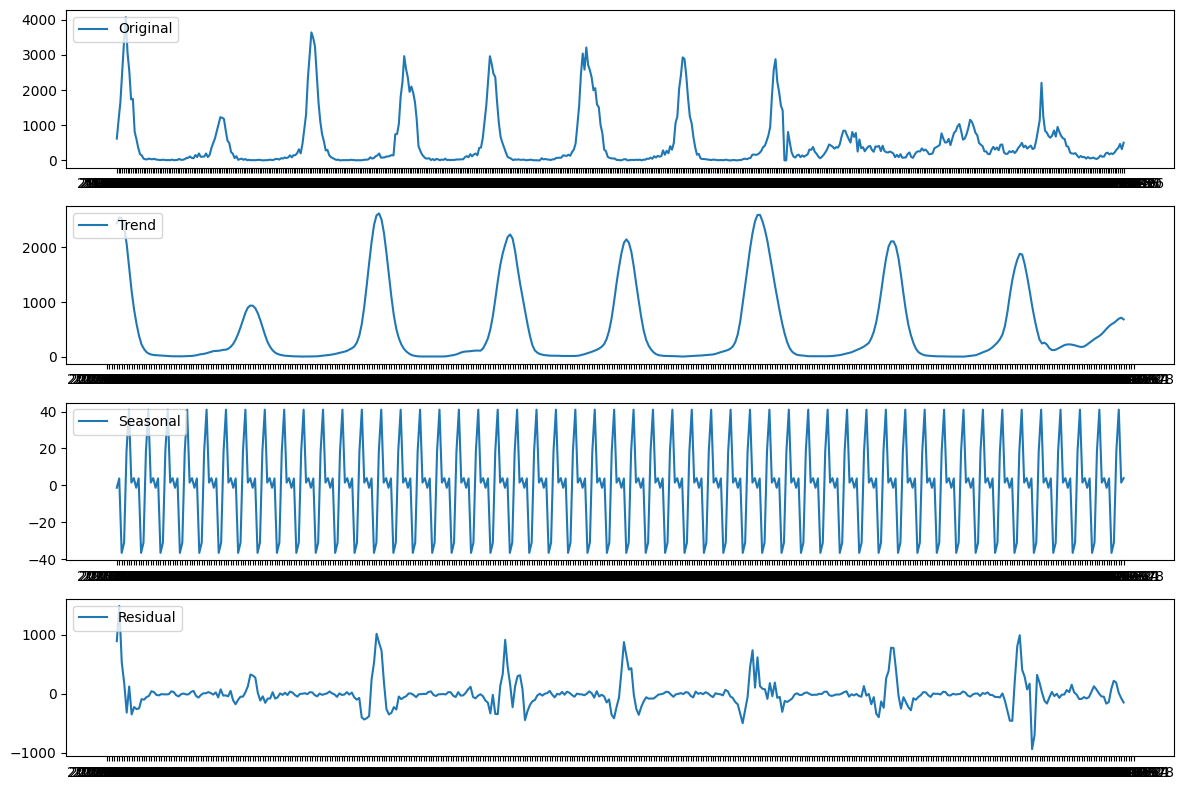

In [137]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomp = seasonal_decompose(train['sampleconsultation_sum'], model='additive', period= 8)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot the components
plt.figure(figsize=(12, 8))

# Original Time Series
plt.subplot(4, 1, 1)
plt.plot(flu_clean_imputed['sampleconsultation_sum'], label='Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# KPSS and ADF

In [138]:
# Perform the KPSS test
result = kpss(train['sampleconsultation_sum'])

# Print the test statistic and p-value
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The time series is stationary (do not reject the null hypothesis), no need for differencing')

KPSS Test Statistic: 0.023164071438662
P-value: 0.1
The time series is stationary (do not reject the null hypothesis), no need for differencing


In [139]:
# Perform the ADF test
result = adfuller(train['sampleconsultation_sum'])

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Test Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Compare the test statistic with critical values to make a decision
if p_value < 0.05:
    print('The time series is stationary (reject the null hypothesis)')
else:
    print('The time series is non-stationary (do not reject the null hypothesis)')


ADF Test Statistic: -5.375579861750748
P-value: 3.8110675316955207e-06
The time series is stationary (reject the null hypothesis)


# ACF and PACF

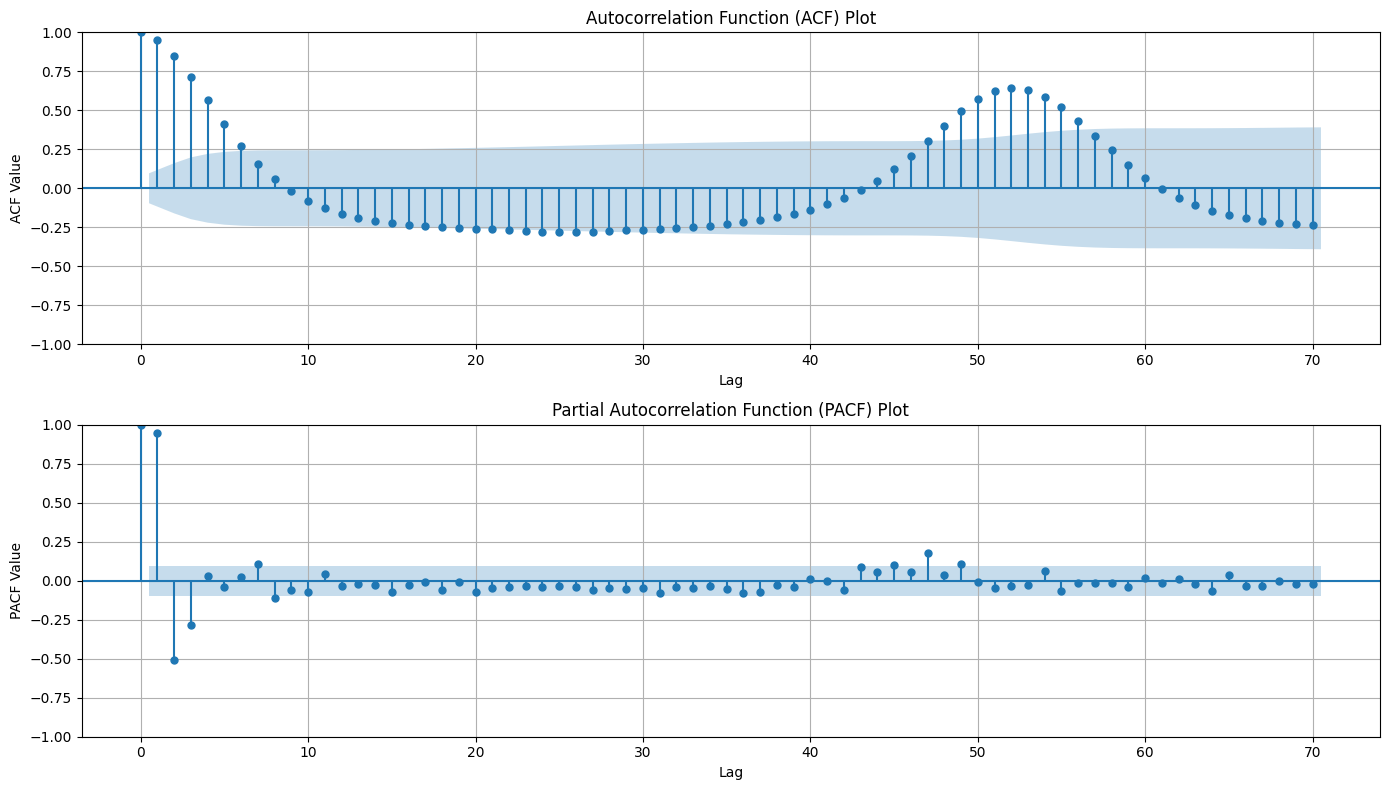

In [140]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(train['sampleconsultation_sum'], lags=70, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(train['sampleconsultation_sum'], lags=70, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show() 
# PACF shows the direct effect of each lag on yt, we can see that lag 1, 2, and 3 have the most impact on yt, and a drastic decaying after lag 3
# the decaying PACF also shows the y is not stationary 
# ACF shows that an order of lag 6 has an effect on yt
# Curving ACF suggests transformation??

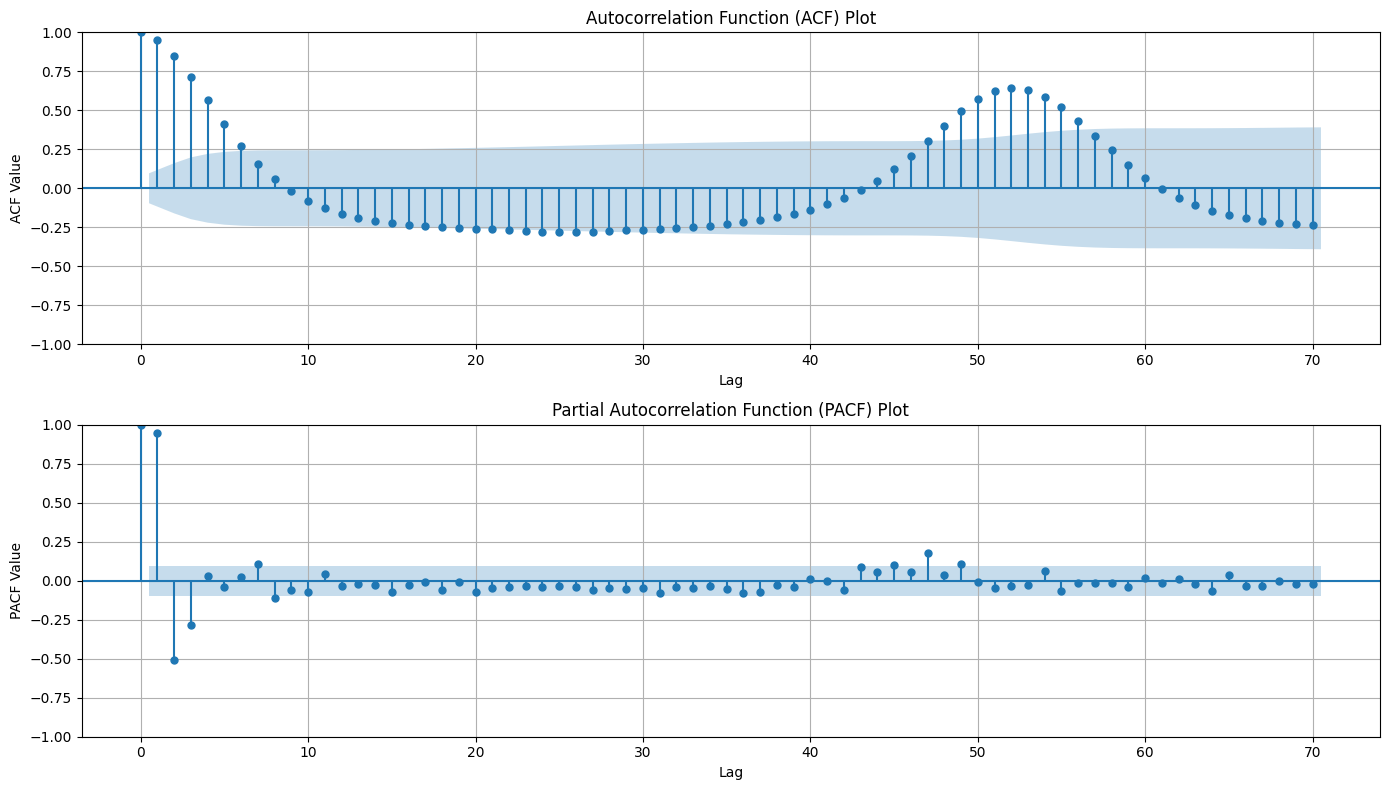

In [141]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(train['sampleconsultation_sum'], lags=70, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(train['sampleconsultation_sum'], lags=70, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show() 

# Log-transformation

In [142]:
flu_clean_imputed['sampleconsultation_log'] = flu_clean_imputed['sampleconsultation_sum'] + 1
y_log = np.log(flu_clean_imputed['sampleconsultation_log'])
if (flu_clean_imputed['sampleconsultation_log'] == 0).any():
    print("There are zeros in the column")
else:
    print("No zeros in the column")
flu_clean_imputed["log"] = y_log
flu_clean_imputed = flu_clean_imputed.rename(columns={'sampleconsultation_sum': 'original'})
flu_clean_imputed = flu_clean_imputed.drop('sampleconsultation_log', axis = 1)
train = flu_clean_imputed[:416]
test = flu_clean_imputed[416:]
print(train)
print(test)

No zeros in the column
               original       log
temporal                         
2013-01-07   618.991084  6.429705
2013-01-14  1153.639593  7.051544
2013-01-21  1650.963391  7.409720
2013-01-28  2486.070312  7.818861
2013-02-04  3344.993948  8.115519
...                 ...       ...
2020-11-30   507.284570  6.231041
2020-12-07   806.917334  6.694460
2020-12-14   666.771190  6.503946
2020-12-21   777.977861  6.657983
2020-12-28   251.760453  5.532442

[416 rows x 2 columns]
              original       log
temporal                        
2021-01-04  593.719333  6.388090
2021-01-11  346.315705  5.850234
2021-01-18  374.134097  5.927284
2021-01-25  258.128708  5.557325
2021-02-01  334.725645  5.816294
...                ...       ...
2023-10-09  304.591134  5.722248
2023-10-16  352.555213  5.868040
2023-10-23  466.613896  6.147643
2023-10-30  318.747040  5.767530
2023-11-06  502.424115  6.221433

[149 rows x 2 columns]


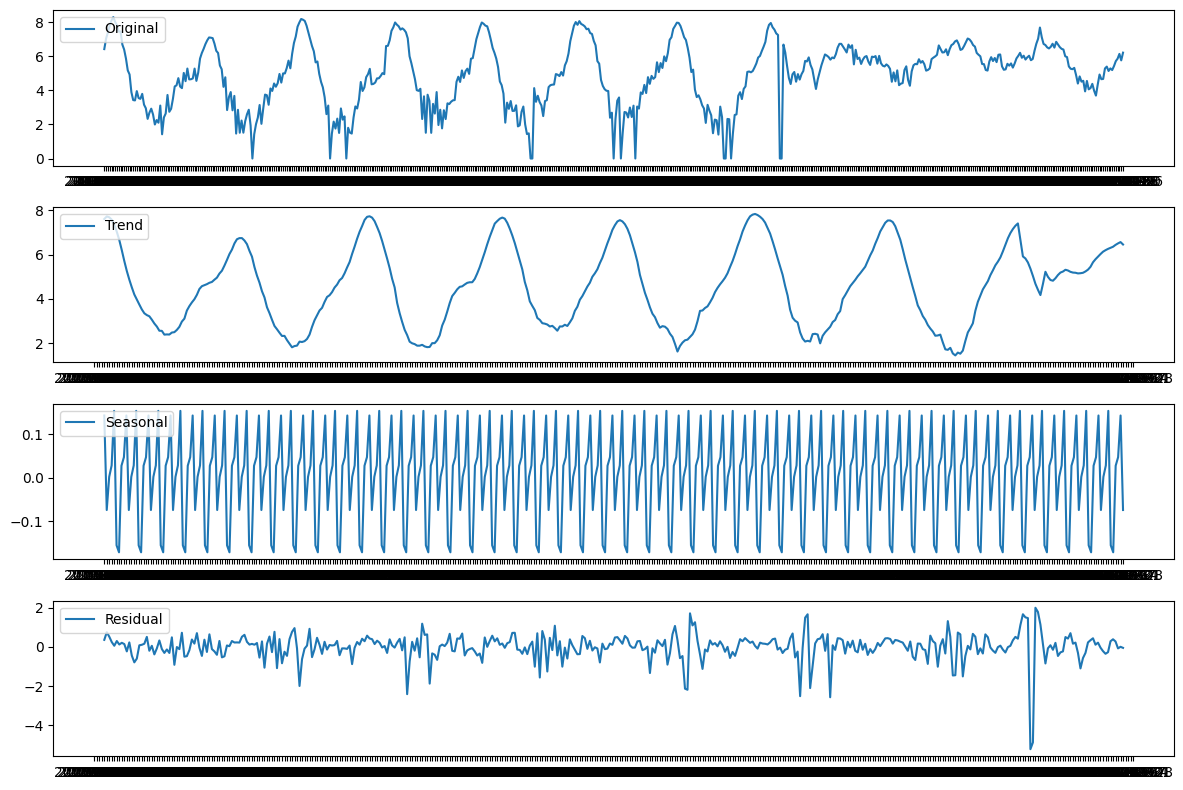

In [143]:
decomp = seasonal_decompose(train['log'], model='additive', period= 9)
trend = decomp.trend
seasonal = decomp.seasonal
residual = decomp.resid

# Plot the components
plt.figure(figsize=(12, 8))

# Original Time Series
plt.subplot(4, 1, 1)
plt.plot(flu_clean_imputed['log'], label='Original')
plt.legend(loc='upper left')

# Trend Component
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')

# Seasonal Component
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

# Residual Component
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()
# The pattern persists after seasonal differencing, which might implies a need for log transformation

# KPSS and ADF with Log_transformation

In [144]:
# Perform the KPSS test
result = kpss(train['log'])

# Print the test statistic and p-value
print(f'KPSS Test Statistic: {result[0]}')
print(f'P-value: {result[1]}')

# Compare the test statistic with critical values to make a decision
if result[1] < 0.05:
    print('The time series is non-stationary (reject the null hypothesis), need for differencing')
else:
    print('The time series is stationary (do not reject the null hypothesis), no need for differencing')

KPSS Test Statistic: 0.06113267977308119
P-value: 0.1
The time series is stationary (do not reject the null hypothesis), no need for differencing


In [145]:
# Perform the ADF test
result = adfuller(train['log'])

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]
print(f'ADF Test Statistic: {adf_statistic}')
print(f'P-value: {p_value}')

# Compare the test statistic with critical values to make a decision
if p_value < 0.05:
    print('The time series is stationary (reject the null hypothesis)')
else:
    print('The time series is non-stationary (do not reject the null hypothesis)')

ADF Test Statistic: -6.340271565809239
P-value: 2.7657201265625845e-08
The time series is stationary (reject the null hypothesis)


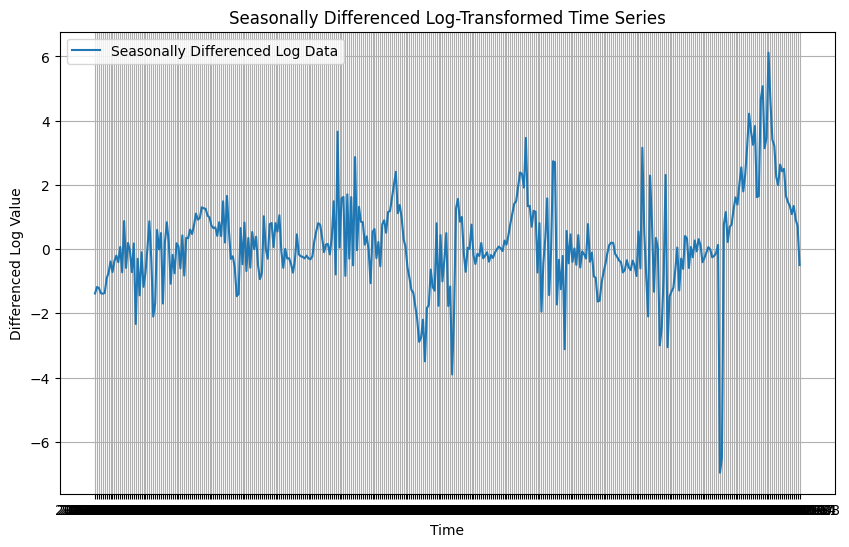

In [146]:
# Define the lag (seasonal period)
lag = 52  # For yearly seasonality (e.g., weekly data)

# Perform seasonal differencing on the log-transformed data
seasonal_differenced_data = train["log"].diff(lag)

# Drop NaN values (resulting from the diff operation)
seasonal_differenced_data = seasonal_differenced_data.dropna()

# Now, seasonal_differenced_data contains the seasonally differenced log-transformed data
plt.figure(figsize=(10, 6))
plt.plot(seasonal_differenced_data, label='Seasonally Differenced Log Data')
plt.title('Seasonally Differenced Log-Transformed Time Series')
plt.xlabel('Time')
plt.ylabel('Differenced Log Value')
plt.legend()
plt.grid()
plt.show()
# After seasonl differencing on log-transformation, it seems to be stationary.

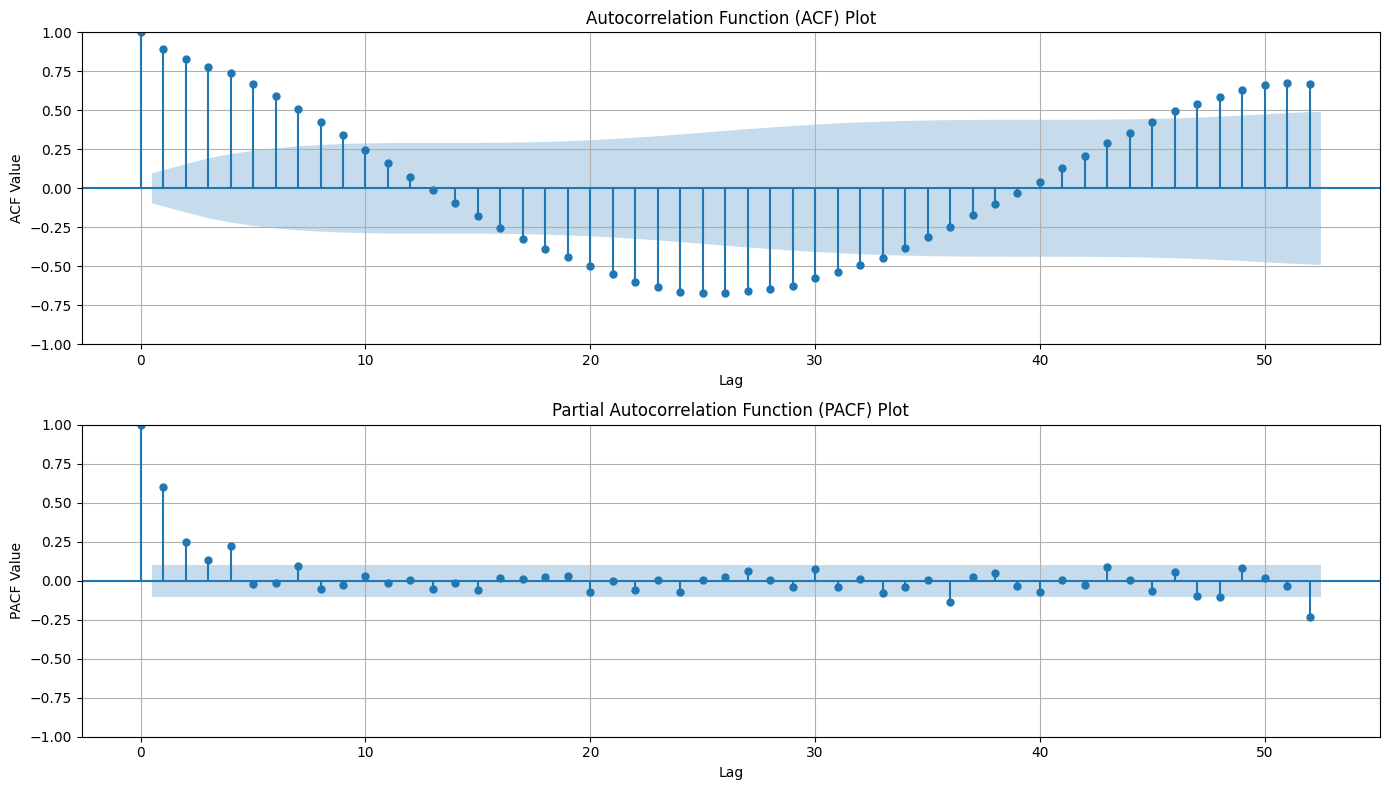

In [147]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(train["log"], lags=52, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(seasonal_differenced_data, lags=52, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show() 
# Seems to have a pattern on ACF with no decay, which could be an indication on non-stationality.
# From ACF and PACF we could induce that the optimum mivong average is 9 and the autoregressive order is 4.

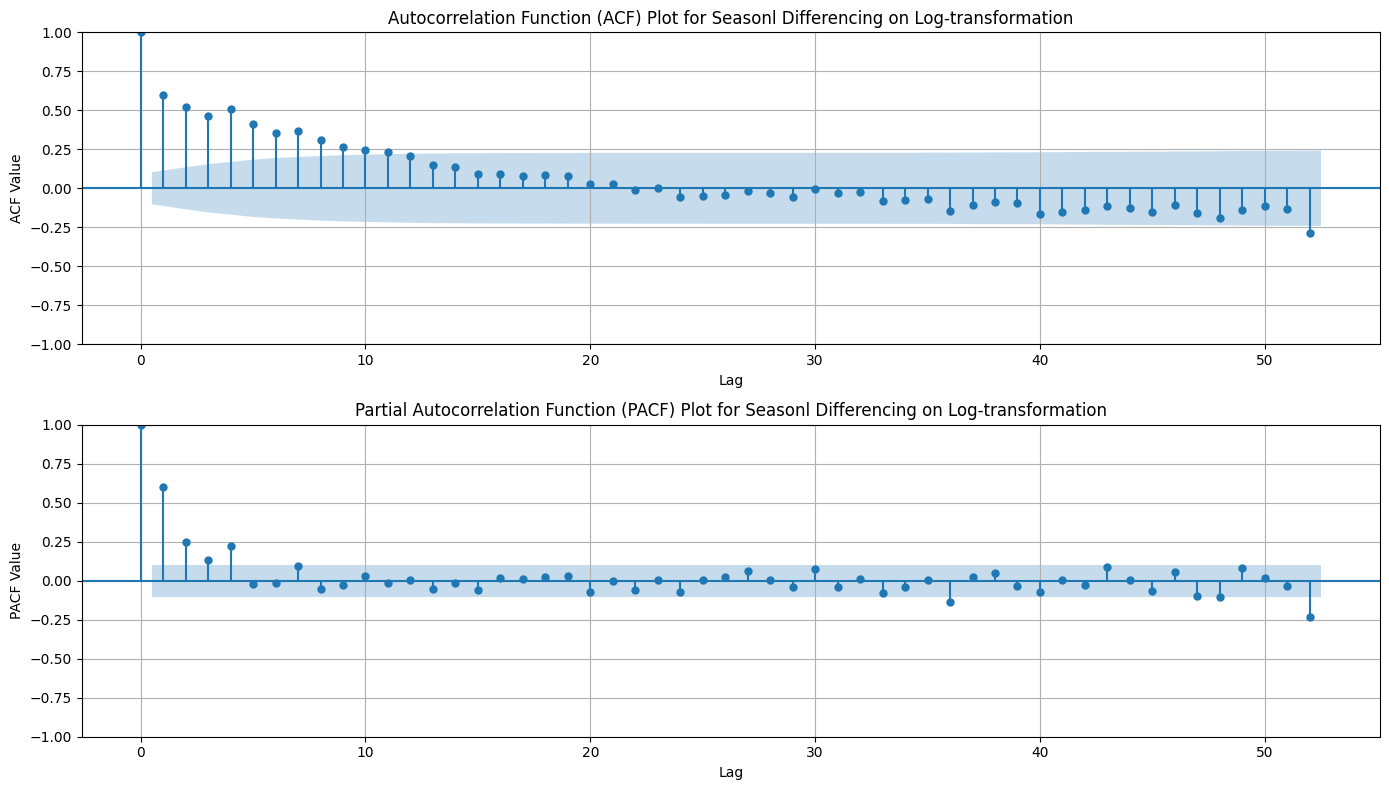

In [148]:
fig, axs = plt.subplots(2, 1, figsize=(14, 8))

# Plot the ACF
plot_acf(seasonal_differenced_data, lags=52, ax=axs[0])  # You can specify the number of lags to display
axs[0].set_title('Autocorrelation Function (ACF) Plot for Seasonl Differencing on Log-transformation')
axs[0].set_xlabel('Lag')
axs[0].set_ylabel('ACF Value')
axs[0].grid()

# Plot the PACF
plot_pacf(seasonal_differenced_data, lags=52, ax=axs[1])  # You can specify the number of lags to display
axs[1].set_title('Partial Autocorrelation Function (PACF) Plot for Seasonl Differencing on Log-transformation')
axs[1].set_xlabel('Lag')
axs[1].set_ylabel('PACF Value')
axs[1].grid()

plt.tight_layout()
plt.show()
# Decay ACF and PACF is a good sign for stationality
#From ACF and PACF we could induce that the optimum mivong average is 12 and the autoregressive order is 4.

# ARIMA

In [171]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
import warnings

warnings.filterwarnings("ignore")

# Finding the optimal ARIMA parameters using AIC (Auto ARIMA can also be used for more rigorous testing)
aic_values = {}
d = 0
for p in range(6):
    for q in range(13):
        try:
            model = ARIMA(train["log"], order=(p, d, q))
            model_arima = model.fit()
            aic_values[(p, d, q)] = model_arima.aic
            print(f"ARIMA({p}, {d}, {q}) with AIC: {model_arima.aic}")

        except:
            continue

# Selecting the best (p, d, q) based on the lowest AIC value
print(aic_values[(p, d, q)])
best_pdq = min(aic_values, key=aic_values.get)
print(best_pdq)
best_pdq, aic_values[best_pdq]
play_audio("take_on_me.mp3")

# Nonetheless, we still try with different parameters without differencing, knowing a lag of 3 from PACF and moving average of 6 from ACF.
# It is likely for ARIMA(4,0,11) to have the best performing parameters with the lowest AIC.
# ARIMA(2,0,11) is the best model according its lowest AIC value. 
# The reason why ARIMA(2,0,11) is the best might due to taking white noises for forecasting.


ARIMA(0, 0, 0) with AIC: 1770.8762317982466
ARIMA(0, 0, 1) with AIC: 1466.7177269782048
ARIMA(0, 0, 2) with AIC: 1309.981499416724
ARIMA(0, 0, 3) with AIC: 1260.067693755076
ARIMA(0, 0, 4) with AIC: 1211.746099528796
ARIMA(0, 0, 5) with AIC: 1178.6452120052236
ARIMA(0, 0, 6) with AIC: 1158.3651095299574
ARIMA(0, 0, 7) with AIC: 1138.7700598825813
ARIMA(0, 0, 8) with AIC: 1128.6640139009794
ARIMA(0, 0, 9) with AIC: 1117.3467070740562
ARIMA(0, 0, 10) with AIC: 1116.0133654466315
ARIMA(0, 0, 11) with AIC: 1108.4059236242388
ARIMA(0, 0, 12) with AIC: 1100.4000237922105
ARIMA(1, 0, 0) with AIC: 1107.7717945801412
ARIMA(1, 0, 1) with AIC: 1095.0703531903337
ARIMA(1, 0, 2) with AIC: 1096.7730163198646
ARIMA(1, 0, 3) with AIC: 1097.5017241712615
ARIMA(1, 0, 4) with AIC: 1085.1538700027902
ARIMA(1, 0, 5) with AIC: 1085.5575763362785
ARIMA(1, 0, 6) with AIC: 1086.356194466849
ARIMA(1, 0, 7) with AIC: 1086.2479382832826
ARIMA(1, 0, 8) with AIC: 1086.7378492342796
ARIMA(1, 0, 9) with AIC: 1085.685

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?


                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                  416
Model:                ARIMA(2, 0, 11)   Log Likelihood                -507.066
Date:                Sun, 03 Dec 2023   AIC                           1044.132
Time:                        23:29:43   BIC                           1104.593
Sample:                             0   HQIC                          1068.038
                                - 416                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5327      0.243     18.672      0.000       4.057       5.008
ar.L1          1.9831      0.003    647.532      0.000       1.977       1.989
ar.L2         -0.9981      0.003   -347.005      0.0

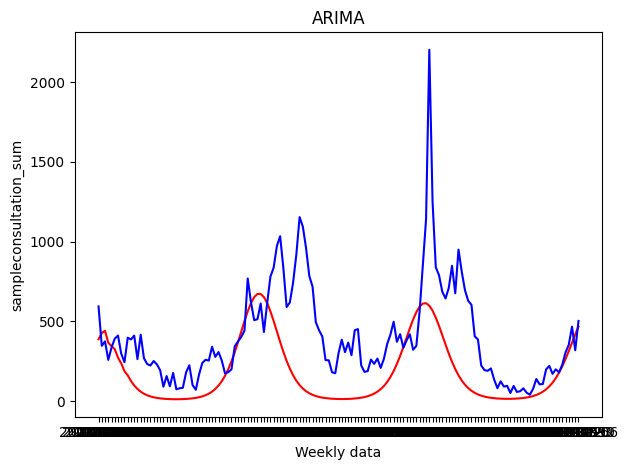

In [173]:
model = ARIMA(train["log"], order=(2, 0, 11))
model_arima = model.fit()
print(model_arima.summary())

pred = model_arima.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
pred = np.exp(pred) - 1
pred_data = pd.DataFrame({'pred': pred})
pred_data.index = test.index
merged = test.join(pred_data, how='inner')

plt.title("ARIMA (2,0,11)")
plt.ylabel("sampleconsultation_sum")
plt.xlabel("Weekly data")
plt.plot(merged["pred"], color = "red", label = "predicted")
plt.plot(merged['original'], color = "blue", label = "actual")
plt.tight_layout()
plt.show
# there seems to be some systematic error in the prediction.

print("RMSE for model ARIMA(2,0,11) is :", mean_squared_error(merged['original'], merged['pred'], squared=False))

                               SARIMAX Results                                
Dep. Variable:                    log   No. Observations:                  416
Model:                ARIMA(4, 0, 11)   Log Likelihood                -506.772
Date:                Sun, 03 Dec 2023   AIC                           1047.544
Time:                        23:57:34   BIC                           1116.066
Sample:                             0   HQIC                          1074.637
                                - 416                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5919      0.209     21.977      0.000       4.182       5.001
ar.L1          0.6095      0.080      7.642      0.000       0.453       0.766
ar.L2          0.7950      0.123      6.476      0.0

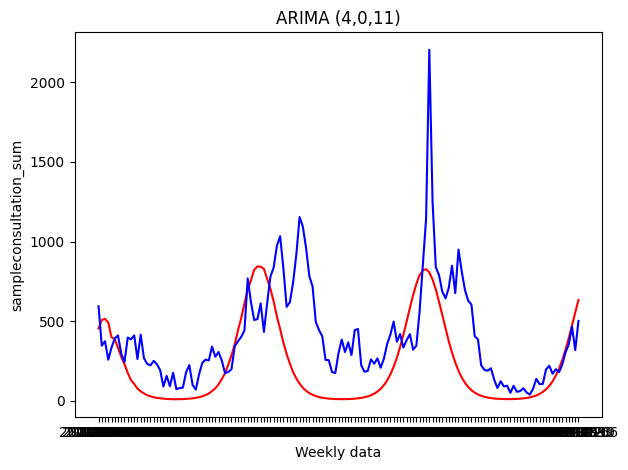

In [176]:
model2 = ARIMA(train["log"], order=(4, 0, 11))
model_arima2 = model2.fit()
print(model_arima2.summary())

pred2 = model_arima2.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
pred2 = np.exp(pred2) - 1
pred_data2 = pd.DataFrame({'pred': pred2})
pred_data2.index = test.index
merged2 = test.join(pred_data2, how='inner')

plt.title("ARIMA (4,0,11)")
plt.ylabel("sampleconsultation_sum")
plt.xlabel("Weekly data")
plt.plot(merged2["pred"], color = "red", label = "predicted")
plt.plot(merged2['original'], color = "blue", label = "actual")
plt.tight_layout()
plt.show

print("RMSE for model ARIMA(4,0,11) is :", mean_squared_error(merged2['original'], merged2['pred'], squared=False))
# Given a higher RMSE score, ARIMA(2,0,11) does seems to be overfitting, so our hyppthesis is right that ARIMA(4,0,11) is a the best performing

expanding cross validation will be used because the dataset is quite small with unexpected spikes

# SARIMA

In [180]:
# Defining and fitting the SARIMA model on the log-transformed data
log_sarima = SARIMAX(train["log"], order=(4, 0, 11), seasonal_order=(4, 1, 10, 52))
log_sarima_model = log_sarima.fit()

# Summary of the SARIMA model fitted on log-transformed data
log_sarima_model.summary()

pred_sarima = log_sarima_model.get_forecast(steps=len(test))
pred_sarima_mean = pred_sarima.predicted_mean


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           30     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30210D+00    |proj g|=  2.57500D-01


 This problem is unconstrained.



At iterate    5    f=  1.17097D+00    |proj g|=  8.73024D-03

At iterate   10    f=  1.16956D+00    |proj g|=  4.73273D-03

At iterate   15    f=  1.16938D+00    |proj g|=  1.45961D-03

At iterate   20    f=  1.16931D+00    |proj g|=  1.47858D-03
